In [1]:
import itertools
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [2]:
df = pd.read_json('logins.json')
display(df.info(), df.head(), df.login_time.min(), df.login_time.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


None

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Timestamp('1970-01-01 20:12:16')

Timestamp('1970-04-13 18:57:38')

In [3]:
df = df.groupby(pd.Grouper(key='login_time', freq='15min')).size().reset_index(name='logins')
df['tod'] = df.login_time.dt.strftime('%H:%M')
# df['hour'] = df.login_time.dt.hour
df_hour = df.groupby(pd.Grouper(key='login_time', freq='H'))['logins'].sum().reset_index(name='logins')
df_hour['hour'] = df_hour.login_time.dt.hour
df_day = df.groupby(pd.Grouper(key='login_time', freq='D'))['logins'].sum().reset_index(name='logins')
df_day['day'] = df_day.login_time.dt.day_of_week

display('******** 15 minute frequency ********', df.head(), 
        '******** 1 hour frequency ********', df_hour.head(), 
        '******** 1 day frequency ********', df_day.head())

'******** 15 minute frequency ********'

,login_time,logins,tod
0,1970-01-01 20:00:00,2,20:00
1,1970-01-01 20:15:00,6,20:15
2,1970-01-01 20:30:00,9,20:30
3,1970-01-01 20:45:00,7,20:45
4,1970-01-01 21:00:00,1,21:00


'******** 1 hour frequency ********'

,login_time,logins,hour
0,1970-01-01 20:00:00,24,20
1,1970-01-01 21:00:00,9,21
2,1970-01-01 22:00:00,21,22
3,1970-01-01 23:00:00,58,23
4,1970-01-02 00:00:00,53,0


'******** 1 day frequency ********'

,login_time,logins,day
0,1970-01-01,112,3
1,1970-01-02,681,4
2,1970-01-03,793,5
3,1970-01-04,788,6
4,1970-01-05,459,0


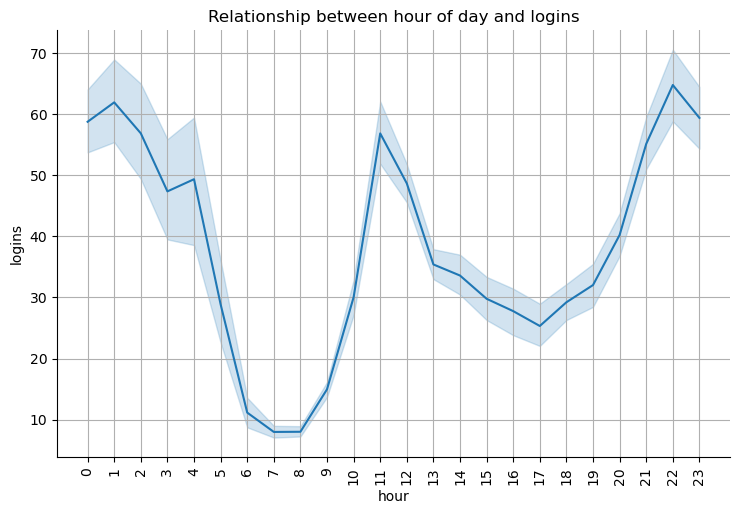

In [4]:
# plt.figure(figsize=(7, 15))
facet = sns.relplot(x='hour', y='logins', data=df_hour, kind='line', aspect=1.5)
custom_ticks = range(24)
plt.title('Relationship between hour of day and logins')
plt.xticks(custom_ticks)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

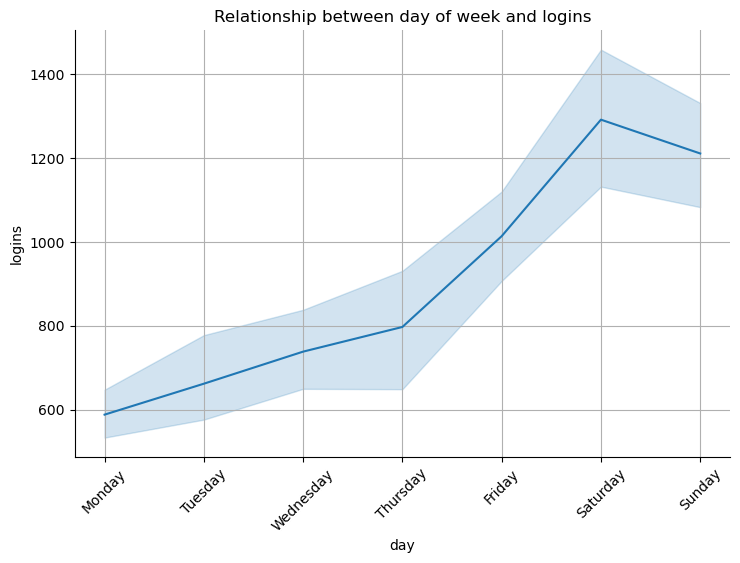

In [5]:
facet = sns.relplot(x='day', y='logins', data=df_day, kind='line', aspect=1.5)
plt.title('Relationship between day of week and logins')
plt.grid(True)
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.show()

# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
 
 - **Answer: Proportion of drivers of who gave rides in both cities over a 7 day period**
 - **I would choose this metric because because this would measure how willing drivers are to serve both cities**
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    * a) how you will implement the experiment
    - **Answer: I will randomly select half of the drivers to be given toll reimbursment over a 7 day period, calling this group A. Group B would be the drivers without any change to their work agreement. Then I will measure the metric of the two groups as described in the answer to question 1. Then I will check if the difference is significant.**
    * b) what statistical test(s) you will conduct to verify the significance of the
observation. 
    - **Answer: I will use a hypothesis test to test significance.**
    - **Null hypothesis: There is no difference between A and B with respect to the metric.**
    - **I would use bootstrapping to take many samples from the data, ignoring the group identity. For each sample I would take the mean of the metric. Then I would I find what percentage of those samples showed a mean metric at least as extreme as group B.**
    * c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

    * **Answer: If less than 5% of the samples showed a mean metric at least as extreme as group B, I would say that the difference is significant and that reimbursing toll costs would result in more drivers being available in both cities. If this was the case I would recommend that the city operations team provide toll reimbursment to drivers. However this is subject to the profit and overall goals of the team. The down side is the revenue lost to reimbursment. The up side is the added profit from more rides and the added brand value of lower wait times for riders. If the benefits outweight the costs then they should go with this program, otherwise they should not.**
    
    
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

    1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
    data for this analysis (a few sentences/plots describing your approach will suffice). What
    fraction of the observed users were retained?
    
    2. Build a predictive model to help Ultimate determine whether or not a user will be active in
    their 6th month on the system. Discuss why you chose your approach, what alternatives
    you considered, and any concerns you have. How valid is your model? Include any key
    indicators of model performance.
    
    3. Briefly discuss how Ultimate might leverage the insights gained from the model to
    improve its long term rider retention (again, a few sentences will suffice).

### Data description
    ● city: city this user signed up in
    ● phone: primary device for this user
    ● signup_date: date of account registration; in the form ‘YYYYMMDD’
    ● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
    ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    ● avg_rating_by_driver: the rider’s average rating over all of their trips
    ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    ● surge_pct: the percent of trips taken with surge multiplier > 1
    ● avg_surge: The average surge multiplier over all of this user’s trips
    ● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
    ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
    otherwise
    ● weekday_pct: the percent of the user’s trips occurring during a weekday

### Load data, create target and EDA
37.6% of the users were retained

In [6]:
df = pd.read_json('ultimate_data_challenge.json')
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


None

In [7]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [8]:
cutoff_date = df['last_trip_date'].max() - pd.Timedelta(days=30)
print(f'target = (last_trip_date >= {cutoff_date}).')
df['target'] = (df.last_trip_date >= cutoff_date).astype(int)

target = (last_trip_date >= 2014-06-01 00:00:00).


In [9]:
df.target.mean()

0.37608

#### EDA
Here I will perform eda only on 1/5th of the data. In this way, I will be able to validate the conclusions of my eda by using the remaining data.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  target                  50000 non-null  int64 

In [11]:
print('First, lets look at the correlation of the numerical columns with the target')
num_corr = df.select_dtypes('number').corr().sort_values('target', ascending=False)
num_corr.loc['target']

First, lets look at the correlation of the numerical columns with the target


trips_in_first_30_days    0.210463
avg_rating_of_driver     -0.011653
avg_surge                -0.003333
surge_pct                 0.011797
weekday_pct               0.009693
avg_dist                 -0.092780
avg_rating_by_driver     -0.026791
target                    1.000000
Name: target, dtype: float64

In [12]:
num_cols = df.select_dtypes('number').columns
cat_cols = df.select_dtypes(exclude=['number']).columns
cat_cols = [c for c in cat_cols if 'date' not in c]

#### Numerical Columns

In [13]:
print('Lets check Nans in our numerical columns')
display(df[num_cols].isna().sum())
print('For the two columns with nans, we may have to impute the nans if we want to use them in modeling.')

Lets check Nans in our numerical columns


trips_in_first_30_days       0
avg_rating_of_driver      8122
avg_surge                    0
surge_pct                    0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
target                       0
dtype: int64

For the two columns with nans, we may have to impute the nans if we want to use them in modeling.


In [14]:
print('Since the target is binary, it might make more sense to look at the mean of each numerical column for each value of the target')
display(df[num_cols].groupby('target').mean())
promising_num_cols = ['trips_in_first_30_days', 'surge_pct', 'weekday_pct', 'avg_dist']
print(f"These columns look possibly promising: {promising_num_cols}")
print('Note: All the promising columns have no nans, so we will not worry about nan imputation for numerical columns')

Since the target is binary, it might make more sense to look at the mean of each numerical column for each value of the target


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
target,,,,,,,
0,1.658482,4.607557,1.075339,8.666739,60.647032,6.207939,4.787464
1,3.306318,4.592930,1.073809,9.152797,61.389034,5.114788,4.762772


These columns look possibly promising: ['trips_in_first_30_days', 'surge_pct', 'weekday_pct', 'avg_dist']
Note: All the promising columns have no nans, so we will not worry about nan imputation for numerical columns


#### Categorical features

In [15]:
print('Looking at nans')
display(df[cat_cols].isna().sum())
print('Note about nans in categorical: These can be seen as another category, although they may be imputed if we deem it useful.')

Looking at nans


city                     0
phone                  396
ultimate_black_user      0
dtype: int64

Note about nans in categorical: These can be seen as another category, although they may be imputed if we deem it useful.


In [16]:
print('For categorical columns, we should look at the value counts and target mean per value')
for col in df[cat_cols].columns: 
    display(f'*********column {col}*********', df[col].value_counts(dropna=False), 
            'target mean per group', 
            df.groupby(col, dropna=False)['target'].mean())
print('All the categorical columns look promising')

For categorical columns, we should look at the value counts and target mean per value


'*********column city*********'

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

'target mean per group'

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: target, dtype: float64

'*********column phone*********'

iPhone     34582
Android    15022
None         396
Name: phone, dtype: int64

'target mean per group'

phone
Android    0.209426
iPhone     0.448933
NaN        0.335859
Name: target, dtype: float64

'*********column ultimate_black_user*********'

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

'target mean per group'

ultimate_black_user
False    0.298818
True     0.503713
Name: target, dtype: float64

All the categorical columns look promising


In [17]:
print('All our categorical columns have low cardinality, so lets see if we can use them to predict the target')
display(df.groupby(cat_cols, dropna=False)['target'].agg(['mean', 'count']).sort_values('mean'))
print('From looking at these groupings, it is clear the combination of city, phone and \n\
"ultimate_black_user" is a very good predictor of the target')

All our categorical columns have low cardinality, so lets see if we can use them to predict the target


mean  count
city           phone   ultimate_black_user                 
Astapor        Android False                0.096159   3515
               NaN     False                0.140000     50
Winterfell     Android False                0.159867   5098
Astapor        Android True                 0.177559   1729
               iPhone  False                0.230437   6492
Winterfell     Android True                 0.272227   2182
               NaN     False                0.282051     78
                       True                 0.323308    133
Astapor        NaN     True                 0.323944     71
King's Landing Android False                0.342785   1587
Winterfell     iPhone  False                0.350085   9989
Astapor        iPhone  True                 0.439812   4677
King's Landing NaN     True                 0.552632     38
Winterfell     iPhone  True                 0.553620   5856
King's Landing iPhone  False                0.596381   4311
               Android True                 0.601537    911
               NaN     False                0.653846     26
               iPhone  True                 0.817317   3257

From looking at these groupings, it is clear the combination of city, phone and 
"ultimate_black_user" is a very good predictor of the target


### Modeling: 
#### Target: probability of user being "Active"
I choose this instead of binary label because it is more flexible. Probabilities can be used to rank our predictions in terms of likelihood of being active. We can always convert our probabilites to a binary label using a threshold that is taylored to our usecase.  

#### Metric: AUC-ROC
This metric will give a measure of how our good our probabilites are across many thresholds. 

#### Models tried: 
* Logistic regression and random forest: Both were tried with various hyperparameters and column choices

* groupby(cat_cols)['target].mean(): tried just with category columns


#### Results
##### Simple Groupby is as good as any model, scoring .76 auc-roc
Just grouping by the categorical columns gives an auc-roc score that is just as good as the best logistic regression or random forest models. This would be my choice of models since it scores the best and is highly explainable. The model simply partitions the customers into groups and takes the mean of the target for each group. 


## Experimentation

In [18]:
for trid, teid in KFold(shuffle=True, random_state=0).split(df): 
    train, test = df.iloc[trid], df.iloc[teid]
    xtr, ytr = train.drop(columns=['target']), train['target']
    xte, yte = test.drop(columns=['target']), test['target']  
    break
xtr.shape, test.shape

((40000, 12), (10000, 13))

#### Can we use Logistic Regression
I would like to use logistic regression since there are nice interpretations of the Beta coefficients. However, if the assumptions of logistic regression are not met. Then the interpretation of our coefficients may not be valid.

#### Multicolinearity check
We don't want high colinearity between the one hot encoded categorical features. Lets check out the correlation given 2 one-hot-encoding schemes; One where don't fill nans or drop dummy columns, and one where we do fill nans and drop a dummy column from each categorical variable.


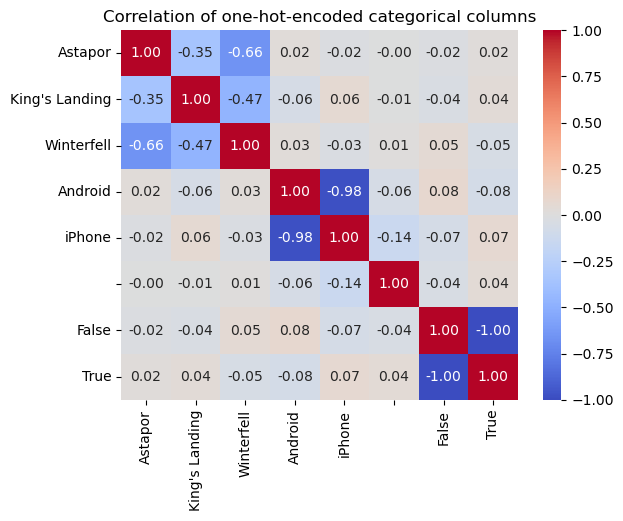

In [19]:
ohe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
ohed = ohe.fit_transform(xtr[cat_cols]).todense()
columns = [c for x in ohe['ohe'].categories_ for c in x]
ohed = pd.DataFrame(ohed, columns = columns)
sns.heatmap(ohed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of one-hot-encoded categorical columns');

["King's Landing", 'Winterfell', 'iPhone', True]


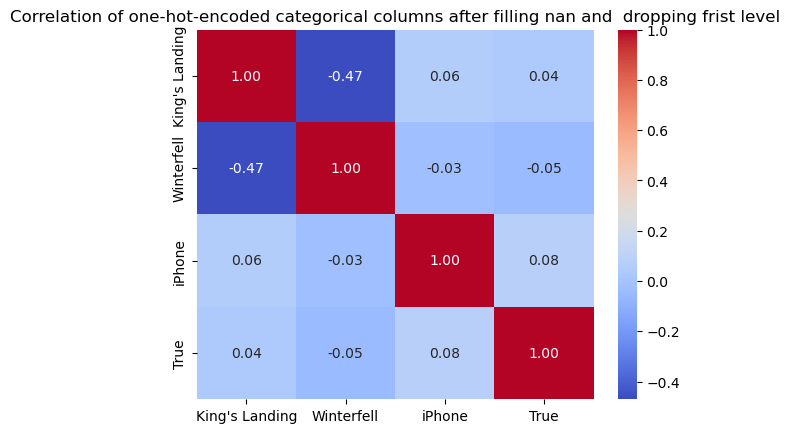

In [20]:
ohe2 = Pipeline([('convert_None2NaN', FunctionTransformer(lambda df: df.fillna(np.nan))),
                ('fillnan', SimpleImputer(strategy='most_frequent')), 
                ('ohe2', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
ohe2d = ohe2.fit_transform(xtr[cat_cols]).todense()
columns = [c for x in ohe2['ohe2'].categories_ for c in x[1:]]
print(columns)
ohe2d = pd.DataFrame(ohe2d, columns = columns)
sns.heatmap(ohe2d.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of one-hot-encoded categorical columns after filling nan and  dropping frist level');

We haven't eliminated all multicolinearity, but lets build a logistic regression model.

In [21]:
def subset_cols(df, cols): return df[cols] if cols else df

In [22]:
lrpipe = Pipeline([
    ('subset_cols', FunctionTransformer(partial(subset_cols, cols=cat_cols))),
    ('ohe2', ohe2), 
    ('lr_model', sklearn.linear_model.LogisticRegression())
])

In [23]:
lrpipe.get_params()

{'memory': None,
 'steps': [('subset_cols',
   FunctionTransformer(func=functools.partial(<function subset_cols at 0x7fde0d778ee0>, cols=['city', 'phone', 'ultimate_black_user']))),
  ('ohe2',
   Pipeline(steps=[('convert_None2NaN',
                    FunctionTransformer(func=<function <lambda> at 0x7fde0e55b1c0>)),
                   ('fillnan', SimpleImputer(strategy='most_frequent')),
                   ('ohe2', OneHotEncoder(drop='first', handle_unknown='ignore'))])),
  ('lr_model', LogisticRegression())],
 'verbose': False,
 'subset_cols': FunctionTransformer(func=functools.partial(<function subset_cols at 0x7fde0d778ee0>, cols=['city', 'phone', 'ultimate_black_user'])),
 'ohe2': Pipeline(steps=[('convert_None2NaN',
                  FunctionTransformer(func=<function <lambda> at 0x7fde0e55b1c0>)),
                 ('fillnan', SimpleImputer(strategy='most_frequent')),
                 ('ohe2', OneHotEncoder(drop='first', handle_unknown='ignore'))]),
 'lr_model': LogisticRegressio

In [24]:
y, x = df['target'], df.drop(columns=['target'])

In [25]:
# cross_validate??

In [26]:
print('Default params roc_auc score')
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['lr_model']
display(pd.DataFrame(model.coef_, columns=columns))

Default params roc_auc score
cv roc_auc score: 0.727558594126918


,King's Landing,Winterfell,iPhone,True
0,1.645034,0.545914,1.07439,0.888597


In [27]:
print('No regularization penalty')
lrpipe.set_params(lr_model__penalty=None)
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['lr_model']
display(pd.DataFrame(model.coef_, columns=columns))
print('the score is identical but the coefficients are slightly larger')

No regularization penalty
cv roc_auc score: 0.727558594126918


,King's Landing,Winterfell,iPhone,True
0,1.647074,0.547089,1.07526,0.889222


the score is identical but the coefficients are slightly larger


In [28]:
%%time
# with warnings.filterwarnings('ignore'): 
param_grid = {
    'lr_model__penalty': ['l1', 'l2'],  # Regularization penalties
    'lr_model__C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'lr_model__solver': ['liblinear', 'saga'],  # Solvers that support the specified penalties
}
grid_search = GridSearchCV(estimator=lrpipe, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(x, y)
best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print(f'best_params: {best_params}, \nbest_score: {best_score}')
# cv_results = pd.DataFrame(grid_search.cv_results_)
# sorted_cv_results = cv_results.sort_values(by='mean_test_score', ascending=False)
# display(sorted_cv_results.head(2))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


best_params: {'lr_model__C': 0.001, 'lr_model__penalty': 'l2', 'lr_model__solver': 'saga'}, 
best_score: 0.7279403646870816
CPU times: user 4.54 s, sys: 582 ms, total: 5.12 s
Wall time: 6.6 s


## Random forest to compare to logistic regression

In [29]:
rfpipe = Pipeline([
    ('subset_cols', FunctionTransformer(partial(subset_cols, cols=cat_cols))),
    ('ohe2', ohe2), 
    ('model', RandomForestClassifier())
])
print('RandomForestClassifier with default params')
m = cross_validate(estimator=rfpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc', n_jobs=-1)
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['model']
# display(pd.DataFrame(model.coef_, columns=columns))
print('the score is identical but the coefficients are slightly larger')
display(pd.Series(model.feature_importances_, 
          index=columns).sort_values(ascending=False).rename('feature_imp').to_frame())

RandomForestClassifier with default params
cv roc_auc score: 0.7278230072763426
the score is identical but the coefficients are slightly larger


,feature_imp
King's Landing,0.423257
iPhone,0.283594
True,0.243486
Winterfell,0.049663


In [30]:
%%time
param_grid = {
    'model__max_depth': [2, 3, 4, 5, 6], 
    'model__max_features': [None], 
    'model__min_samples_split': [2, 4, 16],
}
grid_search = GridSearchCV(estimator=rfpipe, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(x, y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_
print(f'best_params: {best_params}, \nbest_score: {best_score}')
# cv_results = pd.DataFrame(grid_search.cv_results_)
# sorted_cv_results = cv_results.sort_values(by='mean_test_score', ascending=False)
# display(sorted_cv_results.head(2))

best_params: {'model__max_depth': 4, 'model__max_features': None, 'model__min_samples_split': 2}, 
best_score: 0.7278230072763426
CPU times: user 6.98 s, sys: 209 ms, total: 7.19 s
Wall time: 16.9 s


In [31]:
lrpipe = Pipeline([
#     ('subset_cols', FunctionTransformer(partial(subset_cols, cols=''))),
    ('cat_process', ColumnTransformer([
        ('ohe2', ohe2, cat_cols), 
        ('passthrough', 'passthrough', promising_num_cols)
    ])), 
    ('model', sklearn.linear_model.LogisticRegression())
])
print('Logistic regression with categorical columns and promising numerical columns')
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['model']
print('*********************************************')

print('**************Beta Coefficients**************')
display(pd.DataFrame(model.coef_, columns=columns + promising_num_cols))

Logistic regression with categorical columns and promising numerical columns
cv roc_auc score: 0.7592161762543603
*********************************************
**************Beta Coefficients**************


,King's Landing,Winterfell,iPhone,True,trips_in_first_30_days,surge_pct,weekday_pct,avg_dist
0,1.687725,0.533297,1.062256,0.868288,0.120523,0.002462,-0.000042,-0.036204


In [32]:
rem_num_feats = [c for c in num_cols if c not in promising_num_cols + ['target']]
lrpipe = Pipeline([
#     ('subset_cols', FunctionTransformer(partial(subset_cols, cols=''))),
    ('cat_process', ColumnTransformer([
        ('ohe2', ohe2, cat_cols), 
        ('passthrough', 'passthrough', promising_num_cols), 
        ('fillna', SimpleImputer(strategy='mean'), rem_num_feats)
    ])), 
    ('model', sklearn.linear_model.LogisticRegression())
])
print('Logistic regression with categorical columns and all numerical columns')
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['model']
print('*********************************************')

print('**************Beta Coefficients**************')
display(pd.DataFrame(model.coef_, columns=columns + promising_num_cols + rem_num_feats)) 

Logistic regression with categorical columns and all numerical columns
cv roc_auc score: 0.7598569042890337
*********************************************
**************Beta Coefficients**************


,King's Landing,Winterfell,iPhone,True,trips_in_first_30_days,surge_pct,weekday_pct,avg_dist,avg_rating_of_driver,avg_surge,avg_rating_by_driver
0,1.71425,0.498231,1.010497,0.872028,0.117951,0.004284,-0.000079,-0.034875,-0.145216,-0.207052,-0.262622


#### Best logistic regression
Using all features gives the best results. Now lets standardize the features so the coefficients will be more interpretable.

In [33]:
rem_num_feats = [c for c in num_cols if c not in promising_num_cols + ['target']]
lrpipe = Pipeline([
#     ('subset_cols', FunctionTransformer(partial(subset_cols, cols=''))),
    ('cat_process', ColumnTransformer([
        ('ohe2', ohe2, cat_cols), 
        ('passthrough', 'passthrough', promising_num_cols), 
        ('fillna', SimpleImputer(strategy='mean'), rem_num_feats)
        
    ])), 
    ('StandardScaler', sklearn.preprocessing.StandardScaler()), 
    ('model', sklearn.linear_model.LogisticRegression())
])
print('Logistic regression with categorical columns and all numerical columns with feature standardization')
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")
model = m['estimator'][0]['model']
print('*********************************************')

print('**************Beta Coefficients**************')
dfc = pd.DataFrame(model.coef_, columns=columns + promising_num_cols + rem_num_feats)
# display(dfc) 
display(dfc.T.sort_values(0, ascending=False).rename(columns={0: 'Coefficient'}))

Logistic regression with categorical columns and all numerical columns with feature standardization
cv roc_auc score: 0.7601760286843524
*********************************************
**************Beta Coefficients**************


,Coefficient
King's Landing,0.686429
iPhone,0.486167
trips_in_first_30_days,0.456583
True,0.422566
Winterfell,0.258511
surge_pct,0.076649
weekday_pct,0.000526
avg_surge,-0.032924
avg_rating_of_driver,-0.039818
avg_rating_by_driver,-0.068243


In [34]:
# rem_num_feats = [c for c in num_cols if c not in promising_num_cols + ['target']]
# log_values = np.logspace(4, 10, 10)
# # Normalize the values to be between 0 and 1
# normalized_values = (log_values - min(log_values)) / (max(log_values) - min(log_values))
# for C in normalized_values[1:]: 
#     print('#' * 15, 'C', C, '#' * 15)
#     lrpipe = Pipeline([
#     #     ('subset_cols', FunctionTransformer(partial(subset_cols, cols=''))),
#         ('cat_process', ColumnTransformer([
#             ('ohe2', ohe2, cat_cols), 
#             ('passthrough', 'passthrough', promising_num_cols), 
#             ('fillna', SimpleImputer(strategy='mean'), rem_num_feats)

#         ])), 
#         ('StandardScaler', sklearn.preprocessing.StandardScaler()), 
#         ('model', sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C))
#     ])
#     print('Logistic regression with categorical columns and all numerical columns with feature standardization')
#     m = cross_validate(estimator=lrpipe, X=x, y=y, 
#                        return_estimator=True, scoring='roc_auc')
#     print(f"cv roc_auc score: {np.mean(m['test_score'])}")
#     model = m['estimator'][0]['model']
#     print('*********************************************')

#     print('**************Beta Coefficients**************')
#     dfc = pd.DataFrame(model.coef_, columns=columns + promising_num_cols + rem_num_feats)
#     # display(dfc) 
#     display(dfc.T.sort_values(0, ascending=False).rename(columns={0: 'Coefficient'}))

In [35]:
d = df.copy()[cat_cols + ['target']]
d.fillna('most_frequent', inplace=True)

In [36]:
y = df['target']

#### Simple Groupby is as good as any model
Just grouping by the categorical columns gives an auc-roc score that is just as good as the best logistic regression or random forest models. This would be my choice of models since it scores the best and is highly explainable. The model simply partitions the customers into groups and takes the mean of the target for each group. These groups can be looked at as different market segments. 

In [37]:
class GroupbyCatCols: 
    def __init__(self, cat_cols): 
        self.cat_cols = cat_cols
    
    def fit(self, df, y): 
        d = df.copy()
        cat_cols = self.cat_cols
        d['combined_cat'] = d[cat_cols[0]]
        for c in cat_cols[1:]: 
            d['combined_cat'] += '___' + d[c].astype(str)

        mean_dict = df['target'].groupby(d['combined_cat']).mean().to_dict()

        levels = [df[c].unique().astype(str) for c in cat_cols]
        possible = ['___'.join(p) for p in itertools.product(*levels)]
        for p in possible: 
            if p not in mean_dict: 
                print(p, 'not in mean_dict')
                mean_dict[p] = np.mean(y)
        self.mean_dict = mean_dict
    
    def predict_proba(df): 
        d = df.copy()
        cat_cols = self.cat_cols
        d['combined_cat'] = d[cat_cols[0]]
        for c in cat_cols[1:]: 
            d['combined_cat'] += '___' + d[c].astype(str)
        return d['combined_cat'].map(self.mean_dict)
    
    def predict(df): 
        return (self.predict_proba(df) > .5).astype(int)
    
grouppipe = Pipeline([
    ('convert_None2NaN', FunctionTransformer(lambda df: df.fillna(np.nan))),
    ('fillnan', SimpleImputer(strategy='most_frequent')), 
    ('group', GroupbyCatCols(cat_cols))
])
print('Simple groupby categorical column model')
m = cross_validate(estimator=lrpipe, X=x, y=y, 
                   return_estimator=True, scoring='roc_auc')
print(f"cv roc_auc score: {np.mean(m['test_score'])}")

Simple groupby categorical column model
cv roc_auc score: 0.7601760286843524


## Discussion
These groups can be looked at as different market segments. The marketing team could take the segments displayed below and create a marketing plan as they see fit. 



In [38]:
df.groupby(cat_cols)['target'].mean().sort_values(ascending=False).to_frame()

target
city           phone   ultimate_black_user          
King's Landing iPhone  True                 0.817317
               Android True                 0.601537
               iPhone  False                0.596381
Winterfell     iPhone  True                 0.553620
Astapor        iPhone  True                 0.439812
Winterfell     iPhone  False                0.350085
King's Landing Android False                0.342785
Winterfell     Android True                 0.272227
Astapor        iPhone  False                0.230437
               Android True                 0.177559
Winterfell     Android False                0.159867
Astapor        Android False                0.096159